#### LIBRARIES USED

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d

### City Model

The city is represented as a N x N grid, in which there is two kinds of agents, residents and merchants. The residents wants to be in a no so dense region of the city and the merchants want to be in a high density region.

#### FUNCTIONS'S DEFINITIONS

In [205]:
merchant_value = -1
vacancy_value = 0
resident_value = 1

# square neighborhood
# 1:= 3x3; 2:= 5x5; 3:= 7x7; ...
neighborhood = 2
kernel_side = (2*neighborhood+1)
max_neighbors = kernel_side**2 - 1

# densities
minimal_neighbors_resident_density = 0.25
maximal_neighbors_resident_density = 0.8
minimal_neighbors_merchant_density = 0.6
minimal_merchant_neighbors_resident_density = 0.2

# conditions of dissatisfaction Resident
minimal_neighbors_resident = np.round( max_neighbors * minimal_neighbors_resident_density )
maximal_neighbors_resident = np.round( max_neighbors * maximal_neighbors_resident_density )

minimal_merchant_neighbors_resident = np.round(max_neighbors * minimal_merchant_neighbors_resident_density)
maximal_merchant_neighbors_resident = max_neighbors

# conditions of dissatisfaction Merchant
minimal_neighbors_merchant = np.round( max_neighbors * minimal_neighbors_merchant_density )
maximal_neighbors_merchant = max_neighbors

minimal_resident_neighbors_merchant = 0
maximal_resident_neighbors_merchant = max_neighbors

In [213]:
def plot_grid(agents, grid = False):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])  # grey
    agent =  np.array([255.0/255, 255.0/255, 0.0/255])     # red 
    cyan =  np.array([0.0/255, 200.0/255, 255.0/255])      # cyan
    cmap = colors.ListedColormap([cyan, vacancy, agent])
    # determines the limits of each color:
    bounds = [merchant_value, vacancy_value, resident_value, resident_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # hide axis values
    plt.xticks([])  
    plt.yticks([])  

    # draws gridlines
    if grid:
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-0.5, agents.shape[1]))
        ax.set_yticks(np.arange(-0.5, agents.shape[0]))

    plt.show()
    plt.close()

In [214]:
def save_image(agents, grid = False, fileName = "city"):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])  # grey
    agent =  np.array([255.0/255, 255.0/255, 0.0/255])     # red 
    cyan =  np.array([0.0/255, 200.0/255, 255.0/255])      # cyan
    cmap = colors.ListedColormap([vacancy, agent, cyan])
    # determines the limits of each color:
    bounds = [merchant_value, vacancy_value, resident_value, resident_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # hide axis values
    plt.xticks([])  
    plt.yticks([])  

    # draws gridlines
    if grid:
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-0.5, agents.shape[1]))
        ax.set_yticks(np.arange(-0.5, agents.shape[0]))

    plt.savefig(fileName + ".png")
    plt.close()

In [215]:
def create_city(N, agentDensity, residentRelativeDensity, plot = True):
    # creates a city without borders, that will be a toroidal grid
    city = np.zeros(N*N, dtype=np.int8)
    agents = int(agentDensity*N*N)
    residents = int(residentRelativeDensity*agents)
    merchants = agents - residents

    # insert agents according to their densities
    for i in range(N*N):
        if i < residents:
            city[i] = resident_value
        elif residents <= i < residents + merchants:
            city[i] = merchant_value
        else:
            break

    # shuffle agents places
    np.random.shuffle(city)
    # reshape city array to matrix
    city = city.reshape((N,N)) 

    if plot:
        plot_grid(city)
    
    return city

In [216]:
# code by LUCA MINGARELLI https://lucamingarelli.com/Teaching/schelling.html
KERNEL = np.ones((kernel_side, kernel_side), dtype=np.int8)
middle = int(kernel_side/2)
KERNEL[middle][middle] = 0

def evolve(M, boundary='wrap'):
    kws = dict(mode='same', boundary=boundary)
    Resident_neighs = convolve2d(M == resident_value,  KERNEL, **kws)
    Merchant_neighs = convolve2d(M == merchant_value,  KERNEL, **kws)
    Neighs = convolve2d(M != vacancy_value,  KERNEL, **kws)

    # conditions of dissatisfaction
    Resident_dissatisfied = ((((Neighs < minimal_neighbors_resident) | (Neighs > maximal_neighbors_resident)) |                                  # minimal and maximal neighbors                   
                           ((Merchant_neighs < minimal_merchant_neighbors_resident) | (Merchant_neighs > maximal_merchant_neighbors_resident))) & # minimal and maximal merchant neighbors 
                           (M == resident_value))
    Merchant_dissatisfied = ((((Neighs < minimal_neighbors_merchant) | (Neighs > maximal_neighbors_merchant)) |                                  # minimal and maximal neighbors   
                           ((Resident_neighs < minimal_resident_neighbors_merchant) | (Resident_neighs > maximal_resident_neighbors_merchant))) & # minimal and maximal resident neighbors 
                           (M == merchant_value))
    M[Resident_dissatisfied | Merchant_dissatisfied] = vacancy_value
    vacant = (M == vacancy_value).sum()

    N_Resident_dissatisfied, N_Merchant_dissatisfied = Resident_dissatisfied.sum(), Merchant_dissatisfied.sum()
    filling = np.full(vacant, vacancy_value, dtype=np.int8)
    filling[:N_Resident_dissatisfied] = resident_value
    filling[N_Resident_dissatisfied:N_Resident_dissatisfied + N_Merchant_dissatisfied] = merchant_value
    np.random.shuffle(filling)
    M[M==vacancy_value] = filling

In [217]:
def simulate(city, timeSteps = 1000, plot = False, plotEnd = True, saveImage = False, fileName = "city"):
    for i in range(timeSteps):
        # stop condition
        if i%int(timeSteps/10) == 0:
            oldCity = np.copy(city)
            evolve(city)
            dif = oldCity - city
            if all(all(element == 0) for element in dif):
                break

        else:
            evolve(city)

        # time steps in which the city is plotted
        step = 100
        if i != 0 and i%step == 0 and plot:
            plot_grid(city)
            time.sleep(0.1)
            display.clear_output(wait=True)
                
    if plotEnd:
        display.clear_output(wait=True)
        plot_grid(city)

    if saveImage:
        save_image(city, fileName = fileName)

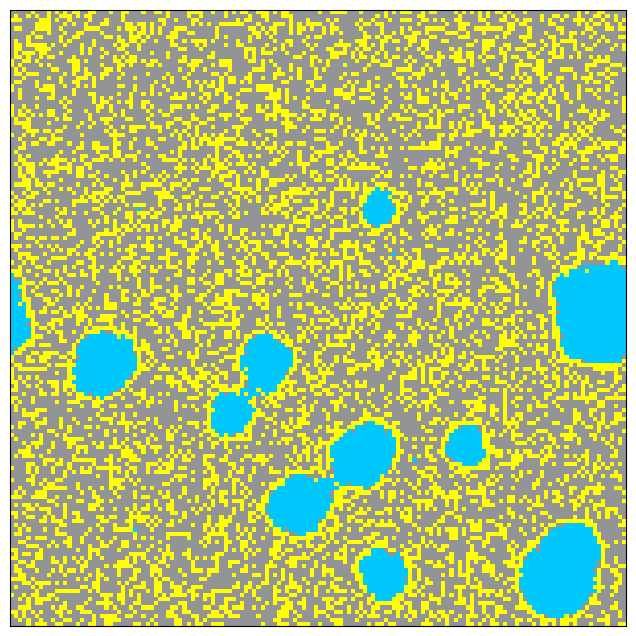

In [284]:
N = 150
agentDensity = 0.4
residentRelativeDensity = 0.8
timeSteps = 1000
plot = True
analizeStart = False

# creates a city
city = create_city(N, agentDensity, residentRelativeDensity)

if analizeStart:
    if int(input()):
        simulate(city, timeSteps, plot = plot)
else:
    simulate(city, timeSteps, plot = plot)

#clusteringLevel = clustering_level(city, residentRelativeDensity)
#print(clusteringLevel)

### Calculating Clustering

In [292]:
KERNEL_CORNER = np.array([[1,1,1],
                          [1,-8,1],
                          [1,1,1]])

def clustering_level(M, boundary='wrap'):
    kws = dict(mode='same', boundary=boundary)
    corners = convolve2d(M != vacancy_value, KERNEL_CORNER, **kws)
    return corners

    """
    # calculate clustering level of merchants
    side = M.shape[0]
    clustering = 0
    agents = agents.sum()
    max_neighbors = KERNEL.sum()
    for i in range(side):
        for j in range(side):
            if M[i][j] != vacancy_value and Neighs[i][j] != 0:
                if M[i][j] == resident_value:
                    #clustering += Merchant_neighs[i][j]/(Neighs[i][j]*residentRelativeDensity)
                    clustering += Merchant_neighs[i][j]
                elif M[i][j] == merchant_value:
                    #clustering += Resident_neighs[i][j]/(Neighs[i][j]*(1-residentRelativeDensity))
                    clustering += Resident_neighs[i][j]
                
    clustering = clustering/2
    return clustering
    """

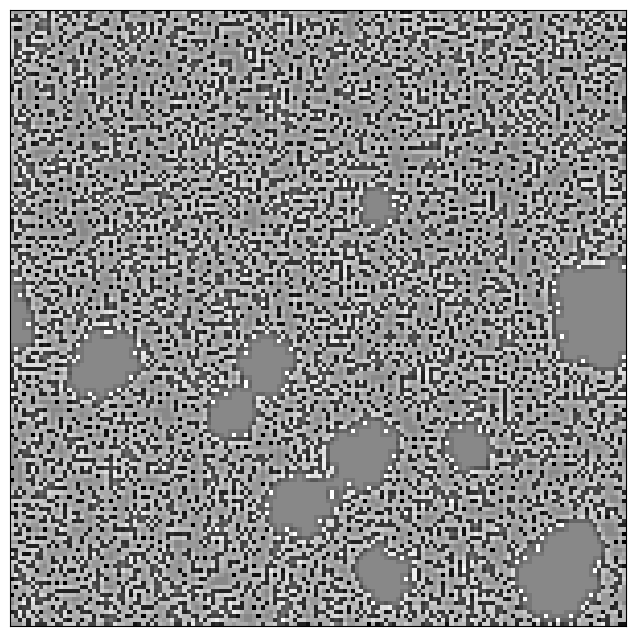

In [303]:
clusteringLevel = clustering_level(city)

def plotar(matrix):
    mini = np.min(matrix)
    maxi = np.max(matrix)
    array = np.arange(mini, maxi)
    nums = len(array)
    colorArray = np.zeros((nums, 3))
    for i in range(nums):
        if nums == 1:
            value = 1
        else:
            value = i*(1/(nums-1))

        colorArray[i] = [value,value,value]
        
    cmap = colors.ListedColormap(colorArray)
    bounds = np.append(array, array[-1] + 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(matrix, cmap=cmap, norm=norm)

    # hide axis values
    plt.xticks([])  
    plt.yticks([])  

    plt.show()
    plt.close()

# Exemplo de uso
plotar(clusteringLevel)

In [281]:
N = 150
agentDensityArray = np.linspace(0.1,1,10)
residentRelativeDensityArray = np.linspace(0.1,0.9,9)
timeSteps = 5000
simulations = 1
plot = False
saveImage = True

results = dict()

for agentDensity in agentDensityArray:
    for residentRelativeDensity in residentRelativeDensityArray:
        clusteringLevel = 0
        fileName = f"({np.round(agentDensity,3)},{np.round(residentRelativeDensity,3)})"
        for i in range(simulations):
            # creates a city
            city = create_city(N, agentDensity, residentRelativeDensity, plot = plot)

            if i == simulations - 1:
                simulate(city, timeSteps, plot = plot, plotEnd = False, saveImage = saveImage, fileName = fileName)
                
            else:
                simulate(city, timeSteps, plot = plot, plotEnd = False)
            
            clusteringLevel += clustering_level(city, residentRelativeDensity)

        clusteringLevel = clusteringLevel/simulations
        results[(np.round(agentDensity,3),np.round(residentRelativeDensity,3))] = np.round(clusteringLevel,5)


KeyboardInterrupt



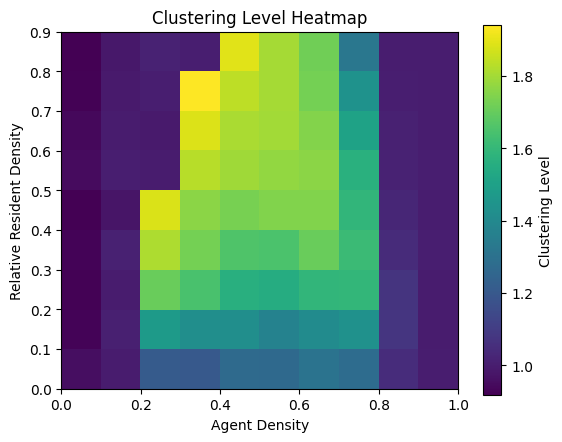

In [160]:
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap(data):
    # Extrair chaves e valores do dicionário
    keys = list(data.keys())
    values = list(data.values())

    # Obter valores únicos de agentDensity e residentRelativeDensity
    agent_density_values = np.unique([key[0] for key in keys])
    relative_density_values = np.unique([key[1] for key in keys])

    # Criar matriz de zeros para armazenar os valores do heatmap
    heatmap_data = np.zeros((len(relative_density_values), len(agent_density_values)))

    # Preencher a matriz com os valores do dicionário
    for i, agent_density in enumerate(agent_density_values):
        for j, relative_density in enumerate(relative_density_values):
            key = (agent_density, relative_density)
            if key in data:
                heatmap_data[j, i] = data[key]

    # Criar o heatmap
    plt.imshow(heatmap_data, cmap='viridis', extent=[0, 1,
                                                    0, 0.9],
               origin='lower', vmin=min(values), vmax=max(values))
    
    plt.colorbar(label='Clustering Level')
    plt.xlabel('Agent Density')
    plt.ylabel('Relative Resident Density')
    plt.title('Clustering Level Heatmap')
    plt.show()

# Exemplo de uso com um dicionário
generate_heatmap(results)

In [70]:
results

{(0.1, 0.1): 0.95497,
 (0.1, 0.2): 0.92761,
 (0.1, 0.3): 0.92564,
 (0.1, 0.4): 0.92923,
 (0.1, 0.5): 0.91921,
 (0.1, 0.6): 0.94953,
 (0.1, 0.7): 0.94074,
 (0.1, 0.8): 0.92486,
 (0.1, 0.9): 0.91825,
 (0.2, 0.1): 0.99446,
 (0.2, 0.2): 1.00912,
 (0.2, 0.3): 0.99778,
 (0.2, 0.4): 1.01009,
 (0.2, 0.5): 0.97441,
 (0.2, 0.6): 1.00331,
 (0.2, 0.7): 0.99786,
 (0.2, 0.8): 0.99225,
 (0.2, 0.9): 0.98264,
 (0.3, 0.1): 1.20999,
 (0.3, 0.2): 1.47554,
 (0.3, 0.3): 1.70559,
 (0.3, 0.4): 1.81382,
 (0.3, 0.5): 1.88146,
 (0.3, 0.6): 0.99499,
 (0.3, 0.7): 0.99369,
 (0.3, 0.8): 1.00337,
 (0.3, 0.9): 1.01474,
 (0.4, 0.1): 1.20352,
 (0.4, 0.2): 1.42131,
 (0.4, 0.3): 1.64648,
 (0.4, 0.4): 1.7275,
 (0.4, 0.5): 1.76412,
 (0.4, 0.6): 1.83033,
 (0.4, 0.7): 1.88646,
 (0.4, 0.8): 1.9401,
 (0.4, 0.9): 1.0036,
 (0.5, 0.1): 1.2712,
 (0.5, 0.2): 1.42291,
 (0.5, 0.3): 1.56098,
 (0.5, 0.4): 1.65763,
 (0.5, 0.5): 1.73134,
 (0.5, 0.6): 1.79481,
 (0.5, 0.7): 1.80921,
 (0.5, 0.8): 1.83939,
 (0.5, 0.9): 1.89516,
 (0.6, 0.1): 1